# Notebook de datos

Este cuadernillo de Python es el primer paso de la parte empírica del TFG. Aquí se recogen tanto los datos de demanda energética, recogidos de la API de e-sios de REDEIA-Red Eléctrica de España, como los de temperatura, obtenidos mediante la librería *meteostat* de Python.

Posteriormente, se tratarán ambos conjuntos de datos para intentar ayudar a próximas estimaciones que se realizarán en el resto de cuadernillos, donde también se estudiará el efecto que estos tratamientos han tenido a la hora de hacer las predicciones.

Una vez tratados los datos, éstos se guardarán en formato *csv* para poder ser usados en el resto de cuadernillos.

In [1]:
# Imports necesarios

import datetime
import matplotlib.pyplot as plt
import hvplot.pandas
import numpy as np
import pandas as pd

from modulo_datos import peticion_indicadores, realiza_peticion_esios, realiza_peticion_temperatura, une_datos
from modulo_datos import guarda_datos_normalizacion, lee_datos_normalizacion, normaliza, total_festivo
from modulo_datos import indice_semana, atras_7n_dias
from modulo_datos import estudio_temperatura

## Obtención de los datos

### Petición de indicadores

El primer paso a realizar será la petición de indicadores a la API de e-sios. Sobre su resultado se buscarán los indicadores que se necesitarán para posteriores peticiones (demanda real y demanda prevista).

In [2]:
peticion_indicadores()

In [3]:
id_demanda_real = 1293
id_prevision_demanda = 544

### Petición de datos de demanda

Una vez obtenidos los indicadores buscados, ya se puede realizar la petición de los datos en sí. Para ello se realizan distintas peticiones a lo largo de un bucle debido a que, al realizar peticiones suficientemente grandes, la API de e-sios puede tardar demasiado en responder, provocando un error HTTP 504. Con la finalidad de evitar dicho error, se define la variable *coeficiente*, que describe la cantidad de días sobre los que se piden datos en cada una de las iteraciones del bucle, con un valor inicial de *50*. Si durante la ejecución del código se obtiene un error, se ha de reducir el valor de la variable *coeficiente*.

In [4]:
dias_atras = 1095 # 3 años

coeficiente = 50
rango = (dias_atras // coeficiente) + 1

dias = [coeficiente*i for i in range(rango) if coeficiente*i<dias_atras]
if dias_atras not in dias:
    dias.append(dias_atras)
dias.reverse()

In [5]:
demanda_real = []
demanda_prevision = []
i = 0
start = datetime.datetime(2024, 1, 1)
while i < len(dias)-1:
    init_aux = start - datetime.timedelta(days=dias[i])
    end_aux = start - datetime.timedelta(days=dias[i+1]+1)
    init = init_aux.strftime("%Y-%m-%d")
    end = end_aux.strftime("%Y-%m-%d")
    demanda_real.append(realiza_peticion_esios(id_demanda_real, init, end))
    demanda_prevision.append(realiza_peticion_esios(id_prevision_demanda, init, end))
    i = i + 1

### Petición de datos de temperatura

A continuación se realiza la petición sobre los datos de temperatura. El rango de días es el mismo que el de la petición de datos sobre demanda energética.

In [6]:
init_total = start - datetime.timedelta(days=dias_atras)
end_total = start - datetime.timedelta(days=1)

In [7]:
temp = realiza_peticion_temperatura(init_total, end_total)

### Unión de los datos

Una vez obtenidos ambos conjuntos de datos, se unen para formar un *dataframe* conjunto con toda la información.

In [8]:
data = une_datos(demanda_real, demanda_prevision, temp)

In [9]:
data

,Indice,Valor,Prevision,Dia,Dia_Semana,Hora,Temperatura,Fecha
0,0,24.179,24.144,2021-01-01,V,00:00:00,4.0,2021-01-01 00:00:00
1,1,22.472,22.451,2021-01-01,V,01:00:00,3.0,2021-01-01 01:00:00
2,2,20.319,20.314,2021-01-01,V,02:00:00,4.0,2021-01-01 02:00:00
3,3,19.040,19.066,2021-01-01,V,03:00:00,4.0,2021-01-01 03:00:00
4,4,18.565,18.638,2021-01-01,V,04:00:00,4.0,2021-01-01 04:00:00
...,...,...,...,...,...,...,...,...
26275,26275,28.979,29.018,2023-12-31,D,19:00:00,5.8,2023-12-31 19:00:00
26276,26276,28.383,27.995,2023-12-31,D,20:00:00,5.7,2023-12-31 20:00:00
26277,26277,25.818,25.348,2023-12-31,D,21:00:00,5.1,2023-12-31 21:00:00
26278,26278,23.627,23.213,2023-12-31,D,22:00:00,4.4,2023-12-31 22:00:00


## Tratamiento de los datos

### Normalizacion de los datos de demanda energética

Primero se normalizan los datos de demanda energética mediante tres técnicas distintas (ver TFG para más información).

Por otra parte, se computarán y guardarán primero todos los cálculos previos a la normalización que serán usados en posteriores cuadernillos, para no tener que repetir estos procesos.

In [10]:
guarda_datos_normalizacion(data)

In [11]:
medias_festivos = lee_datos_normalizacion("festivos")
medias_laborables = lee_datos_normalizacion("laborables")
medias_sabados = lee_datos_normalizacion("sabados")

In [12]:
normalizados1 = []

for i in range(len(data['Valor'])):
    c = normaliza(data['Dia_Semana'][i], data['Dia'][i], data['Hora'][i], medias_laborables, medias_festivos, medias_sabados)
    dato = c * data['Valor'][i]
    normalizados1.append(dato)

data['Valor_Normalizado1'] = normalizados1

In [13]:
normalizados2 = []

for i in range(len(data['Valor'])):
    if i < 24*7:
        normalizados2.append(1.0)
    elif total_festivo(data['Dia'][i], data['Dia_Semana'][i]):
        j = (indice_semana(data['Dia_Semana'][i]) + 1) % 7
        if j == 0:
            j = 7
        if i-24*j < 0:
            dato = 1.0
        else:
            dato = data['Valor'][i] / data['Valor'][i-(24*j)]
        normalizados2.append(dato)
    else:
        n = 1
        while(total_festivo(atras_7n_dias(n, data['Dia'][i]), data['Dia_Semana'][i])):
            n = n + 1
        if i-24*7*n < 0:
            dato = 1.0
        else:
            dato = data['Valor'][i] / data['Valor'][i-24*7*n]
        normalizados2.append(dato)

data['Valor_Normalizado2'] = normalizados2

In [14]:
normalizados3_7d = []

for i in range(len(data['Valor'])):
    if i < 24*7:
        normalizados3_7d.append(1.0)
    else:
        dato = data['Valor_Normalizado1'][i] / data['Valor_Normalizado1'][i-24*7]
        normalizados3_7d.append(dato)

data['Valor_Normalizado3_7d'] = normalizados3_7d

normalizados3_1d = []

for i in range(len(data['Valor'])):
    if i < 24:
        normalizados3_1d.append(1.0)
    else:
        dato = data['Valor_Normalizado1'][i] / data['Valor_Normalizado1'][i-24]
        normalizados3_1d.append(dato)

data['Valor_Normalizado3_1d'] = normalizados3_1d

### Tratamiento de la temperatura

Ahora se estudia el centrado de los valores de la temperatura, dependiendo de la normalización de los datos de demanda energética asociados (ver TFG para más información).

In [15]:
l_t = [10.0+k for k in range(16)]

l_corr0, cor0 = estudio_temperatura(data['Temperatura'], data['Valor'], l_t, pot=2)
l_corr1, cor1 = estudio_temperatura(data['Temperatura'], data['Valor_Normalizado1'], l_t, pot=2)
l_corr2, cor2 = estudio_temperatura(data['Temperatura'], data['Valor_Normalizado2'], l_t, pot=2)
l_corr37, cor37 = estudio_temperatura(data['Temperatura'], data['Valor_Normalizado3_7d'], l_t, pot=2)
l_corr31, cor31 = estudio_temperatura(data['Temperatura'], data['Valor_Normalizado3_1d'], l_t, pot=2)

En las siguientes gráficas se pueden observar dichos estudios. Las lineas naranjas indican, en cada caso, la correlación de los datos de demanda energética con la temperatura sin centrar.

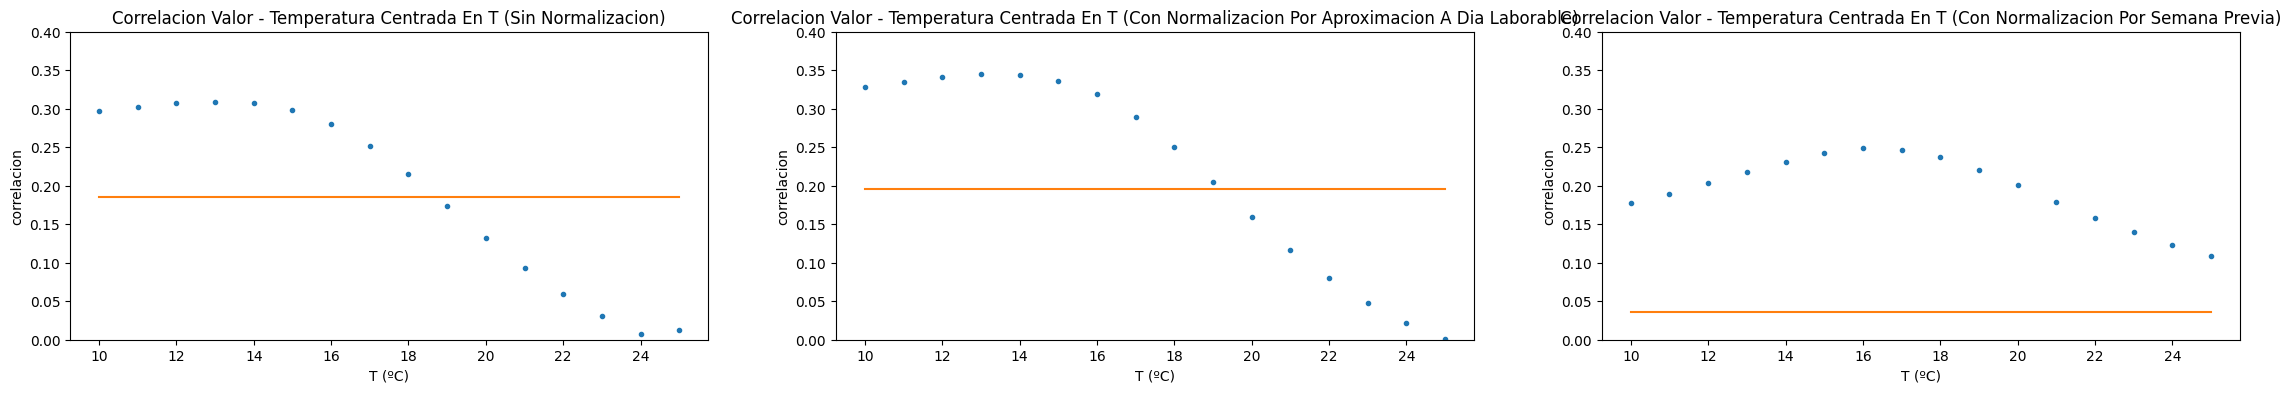

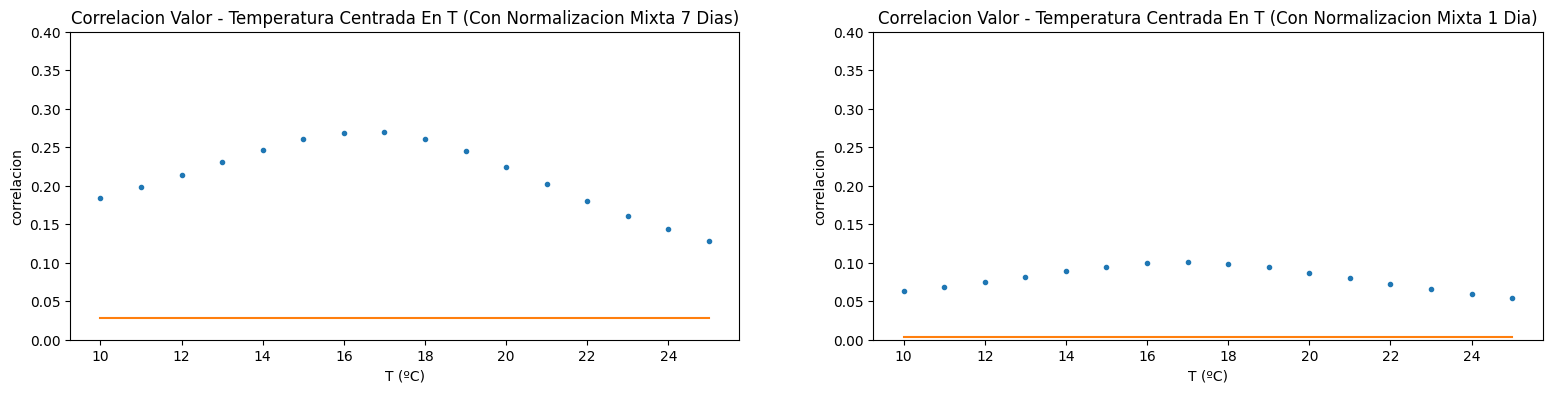

In [16]:
ancho = 28
alto = 4
plt.figure(figsize=(ancho,alto))

plt.subplot(1, 3, 1)
plt.plot(l_t, l_corr0, '.')
plt.plot(l_t, [cor0 for _ in l_t])
plt.title('Correlacion Valor - Temperatura Centrada En T (Sin Normalizacion)')
plt.xlabel('T (ºC)')
plt.ylabel('correlacion')
plt.ylim([0.0, 0.4])

plt.subplot(1, 3, 2)
plt.plot(l_t, l_corr1, '.')
plt.plot(l_t, [cor1 for _ in l_t])
plt.title('Correlacion Valor - Temperatura Centrada En T (Con Normalizacion Por Aproximacion A Dia Laborable)')
plt.xlabel('T (ºC)')
plt.ylabel('correlacion')
plt.ylim([0.0, 0.4])

plt.subplot(1, 3, 3)
plt.plot(l_t, l_corr2, '.')
plt.plot(l_t, [cor2 for _ in l_t])
plt.title('Correlacion Valor - Temperatura Centrada En T (Con Normalizacion Por Semana Previa)')
plt.xlabel('T (ºC)')
plt.ylabel('correlacion')
plt.ylim([0.0, 0.4])

plt.show()

ancho = 19
plt.figure(figsize=(ancho,alto))

plt.subplot(1, 2, 1)
plt.plot(l_t, l_corr37, '.')
plt.plot(l_t, [cor37 for _ in l_t])
plt.title('Correlacion Valor - Temperatura Centrada En T (Con Normalizacion Mixta 7 Dias)')
plt.xlabel('T (ºC)')
plt.ylabel('correlacion')
plt.ylim([0.0, 0.4])

plt.subplot(1, 2, 2)
plt.plot(l_t, l_corr31, '.')
plt.plot(l_t, [cor31 for _ in l_t])
plt.title('Correlacion Valor - Temperatura Centrada En T (Con Normalizacion Mixta 1 Dia)')
plt.xlabel('T (ºC)')
plt.ylabel('correlacion')
plt.ylim([0.0, 0.4])

plt.show()

Y finalmente se añaden al *dataframe* las temperaturas centradas.

In [17]:
t0 = 13.0
t1 = 13.0
t2 = 16.0
t37 = 17.0
t31 = 17.0

l_t0 = []
l_t1 = []
l_t2 = []
l_t37 = []
l_t31 = []

for i in range(len(data['Valor'])):
    l_t0.append(abs(t0-data['Temperatura'][i])**2)
    l_t1.append(abs(t1-data['Temperatura'][i])**2)
    l_t2.append(abs(t2-data['Temperatura'][i])**2)
    l_t37.append(abs(t37-data['Temperatura'][i])**2)
    l_t31.append(abs(t31-data['Temperatura'][i])**2)

data['Temperatura_Centrada0'] = l_t0
data['Temperatura_Centrada1'] = l_t1
data['Temperatura_Centrada2'] = l_t2
data['Temperatura_Centrada3_7d'] = l_t37
data['Temperatura_Centrada3_1d'] = l_t31

### Visualizaciones finales

Se mostrarán a continuación distintos gráficos y cálculos sobre los datos tratados.

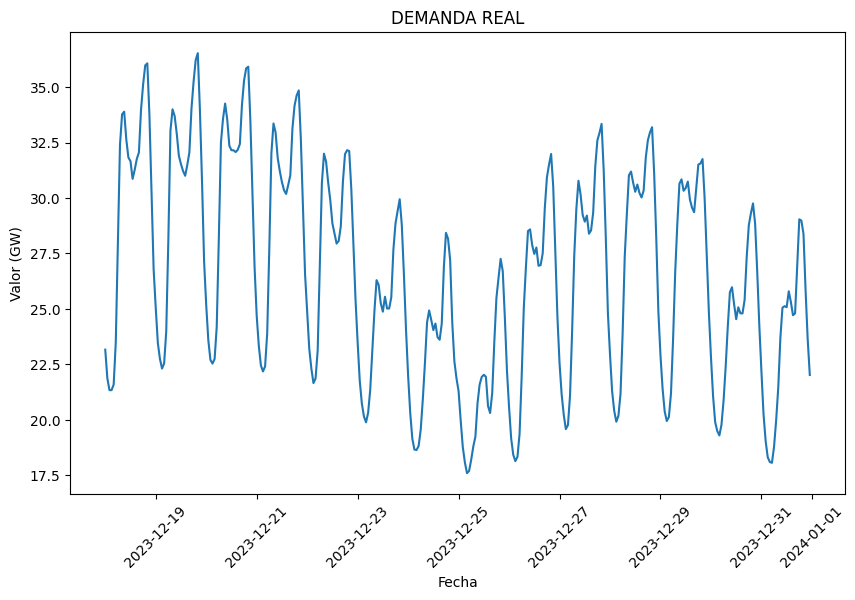

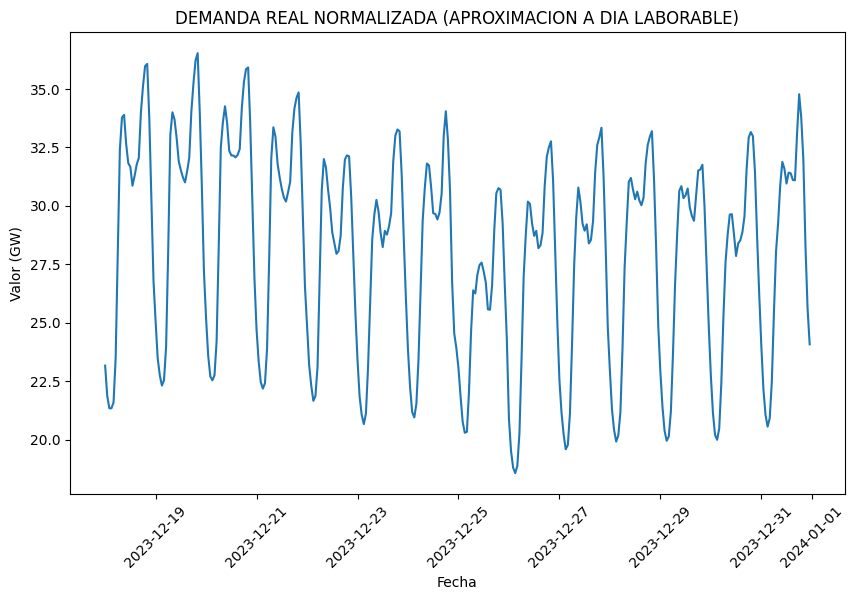

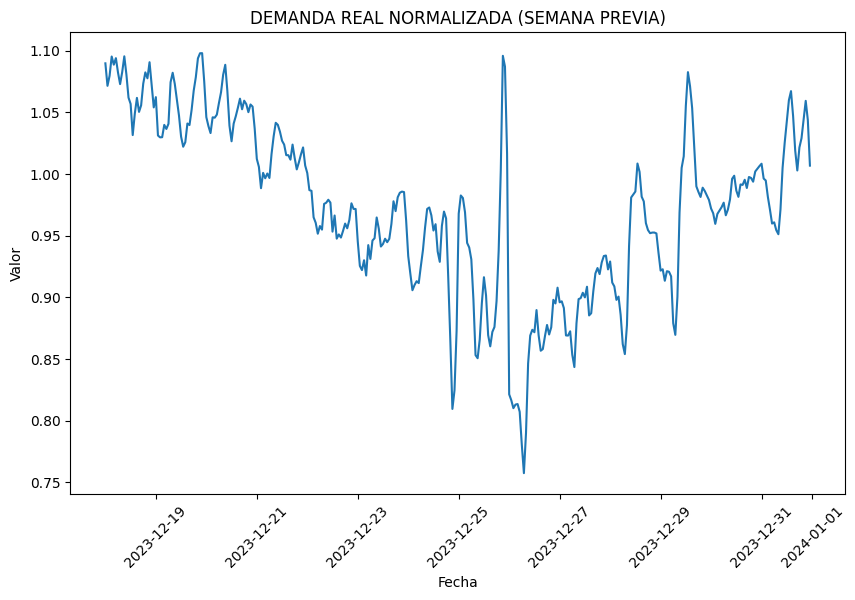

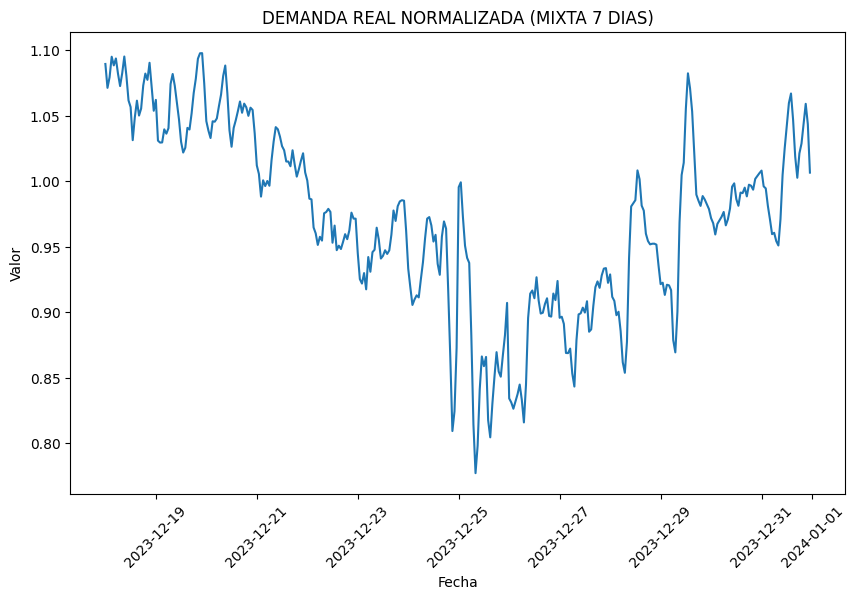

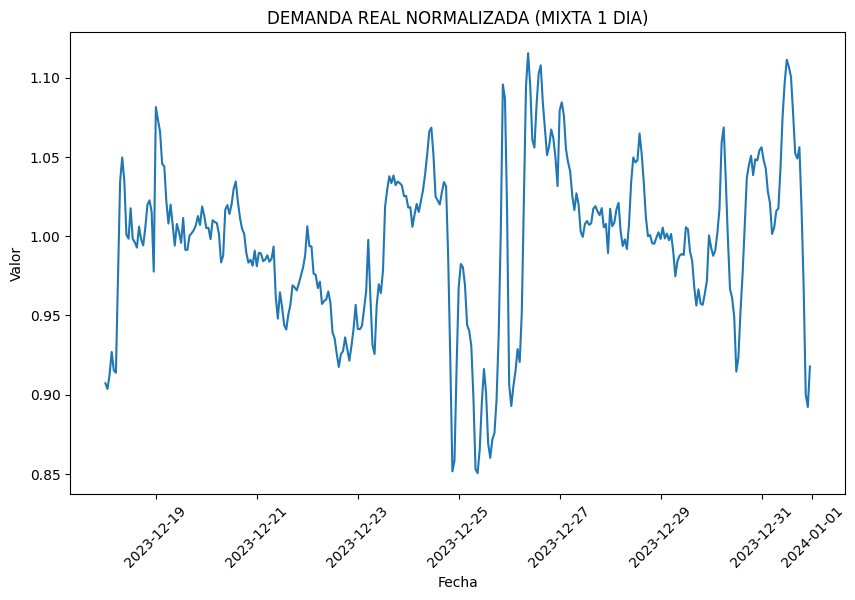

In [18]:
n_datos = 7 * 24 * 2

long = len(data['Valor'])

indices = data['Fecha'][long-n_datos:]

ancho = 10
alto = 6

plt.figure(figsize=(ancho,alto))
plt.plot(indices, data['Valor'][long-n_datos:])
plt.xticks(rotation=45)
plt.title("DEMANDA REAL")
plt.xlabel("Fecha")
plt.ylabel("Valor (GW)")
plt.show()

plt.figure(figsize=(ancho,alto))
plt.plot(indices, data['Valor_Normalizado1'][long-n_datos:])
plt.xticks(rotation=45)
plt.title("DEMANDA REAL NORMALIZADA (APROXIMACION A DIA LABORABLE)")
plt.xlabel("Fecha")
plt.ylabel("Valor (GW)")
plt.show()

plt.figure(figsize=(ancho,alto))
plt.plot(indices, data['Valor_Normalizado2'][long-n_datos:])
plt.xticks(rotation=45)
plt.title("DEMANDA REAL NORMALIZADA (SEMANA PREVIA)")
plt.xlabel("Fecha")
plt.ylabel("Valor")
plt.show()

plt.figure(figsize=(ancho,alto))
plt.plot(indices, data['Valor_Normalizado3_7d'][long-n_datos:])
plt.xticks(rotation=45)
plt.title("DEMANDA REAL NORMALIZADA (MIXTA 7 DIAS)")
plt.xlabel("Fecha")
plt.ylabel("Valor")
plt.show()

plt.figure(figsize=(ancho,alto))
plt.plot(indices, data['Valor_Normalizado3_1d'][long-n_datos:])
plt.xticks(rotation=45)
plt.title("DEMANDA REAL NORMALIZADA (MIXTA 1 DIA)")
plt.xlabel("Fecha")
plt.ylabel("Valor")
plt.show()

In [19]:
media1 = data['Valor'].mean()
varianza1 = data['Valor'].var()
print("MEDIA REAL: " + str(media1))
print("VARIANZA REAL: " + str(varianza1))

media2 = data['Valor_Normalizado1'].mean()
varianza2 = data['Valor_Normalizado1'].var()
print("MEDIA NORMALIZADA (APROXIMACION A DIA LABORABLE): " + str(media2))
print("VARIANZA NORMALIZADA (APROXIMACION A DIA LABORABLE): " + str(varianza2))

media3 = data['Valor_Normalizado2'].mean()
varianza3 = data['Valor_Normalizado2'].var()
print("MEDIA NORMALIZADA (SEMANA PREVIA): " + str(media3))
print("VARIANZA NORMALIZADA (SEMANA PREVIA): " + str(varianza3))

media4 = data['Valor_Normalizado3_7d'].mean()
varianza4 = data['Valor_Normalizado3_7d'].var()
print("MEDIA NORMALIZADA (MIXTA 7 DIAS): " + str(media4))
print("VARIANZA NORMALIZADA (MIXTA 7 DIAS): " + str(varianza4))

media5 = data['Valor_Normalizado3_1d'].mean()
varianza5 = data['Valor_Normalizado3_1d'].var()
print("MEDIA NORMALIZADA (MIXTA 1 DIA): " + str(media5))
print("VARIANZA NORMALIZADA (MIXTA 1 DIA): " + str(varianza5))

MEDIA REAL: 26.908318987823442
VARIANZA REAL: 18.69466143167263
MEDIA NORMALIZADA (APROXIMACION A DIA LABORABLE): 28.20711371471529
VARIANZA NORMALIZADA (APROXIMACION A DIA LABORABLE): 17.294438602084032
MEDIA NORMALIZADA (SEMANA PREVIA): 1.000954520192047
VARIANZA NORMALIZADA (SEMANA PREVIA): 0.00367448164238267
MEDIA NORMALIZADA (MIXTA 7 DIAS): 1.0006674749255673
VARIANZA NORMALIZADA (MIXTA 7 DIAS): 0.003306684934243021
MEDIA NORMALIZADA (MIXTA 1 DIA): 1.0006913101392667
VARIANZA NORMALIZADA (MIXTA 1 DIA): 0.001425784973064174


In [20]:
data.hvplot.line(x='Fecha', y='Valor')

:Curve   [Fecha]   (Valor)

In [21]:
data.hvplot.line(x='Fecha', y='Valor_Normalizado1')

:Curve   [Fecha]   (Valor_Normalizado1)

In [22]:
data.hvplot.line(x='Fecha', y='Valor_Normalizado2')

:Curve   [Fecha]   (Valor_Normalizado2)

In [23]:
data.hvplot.line(x='Fecha', y='Valor_Normalizado3_7d')

:Curve   [Fecha]   (Valor_Normalizado3_7d)

In [24]:
data.hvplot.line(x='Fecha', y='Valor_Normalizado3_1d')

:Curve   [Fecha]   (Valor_Normalizado3_1d)

Además, se muestran a continuación histogramas de los distintos valores de demanda para las distintas normalizaciones.

In [25]:
bins = [15 + 1.25*k for k in range(25)]
bins2 = [0.6 + 0.0333*k for k in range(25)]

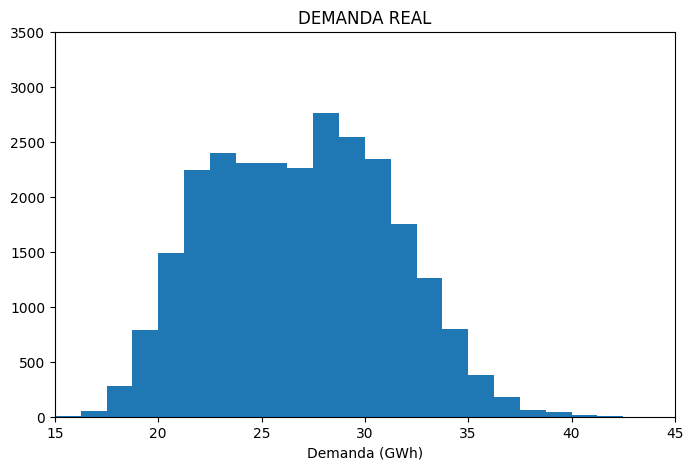

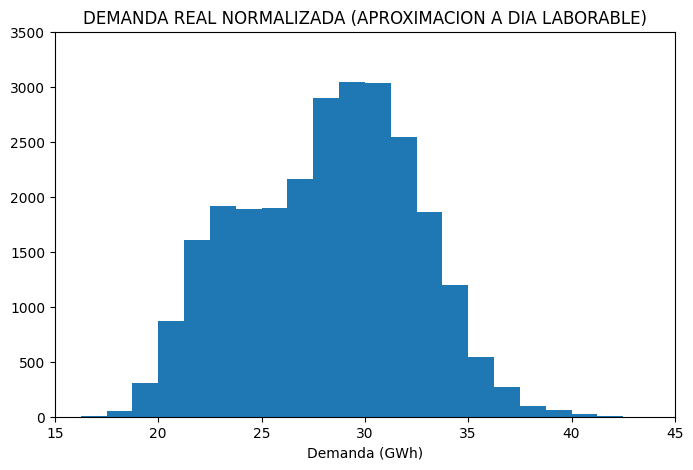

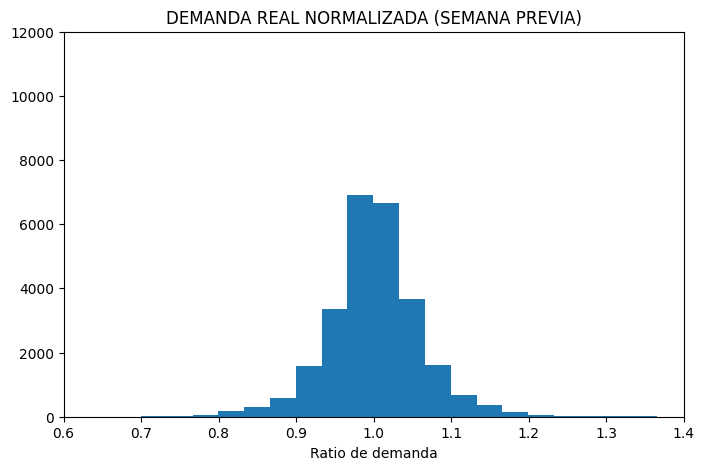

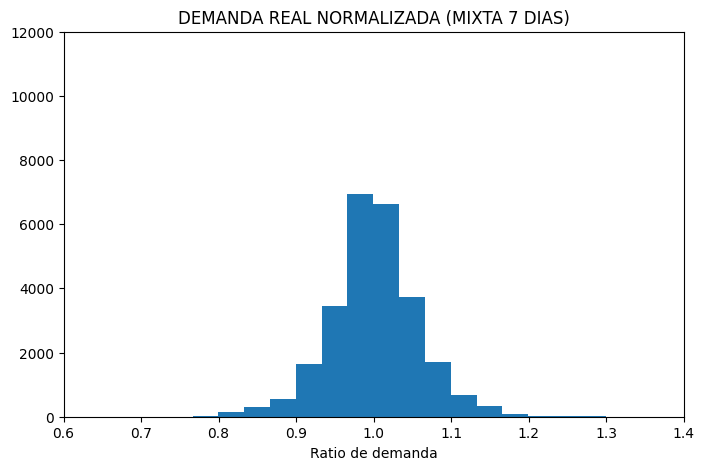

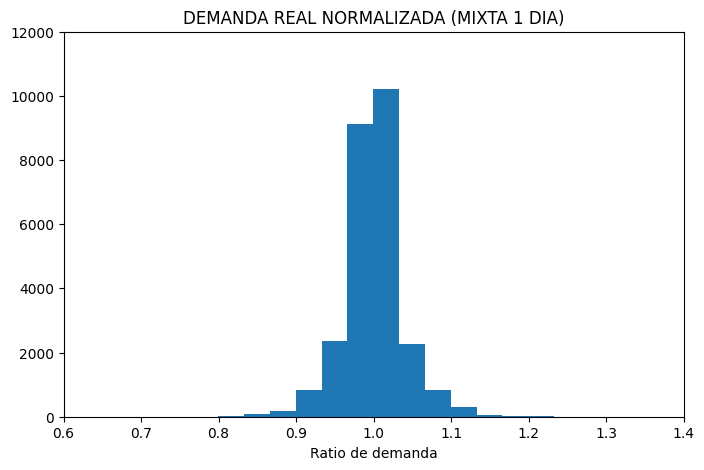

In [26]:
ancho = 8
alto = 5

plt.figure(figsize=(ancho,alto))
plt.title("DEMANDA REAL")
plt.hist(data['Valor'], bins=bins)
plt.xlim([15,45])
plt.ylim([0, 3500])
plt.xlabel("Demanda (GWh)")
plt.show()

plt.figure(figsize=(ancho,alto))
plt.title("DEMANDA REAL NORMALIZADA (APROXIMACION A DIA LABORABLE)")
plt.hist(data['Valor_Normalizado1'], bins=bins)
plt.xlim([15,45])
plt.ylim([0, 3500])
plt.xlabel("Demanda (GWh)")
plt.show()

plt.figure(figsize=(ancho,alto))
plt.title("DEMANDA REAL NORMALIZADA (SEMANA PREVIA)")
plt.hist(data['Valor_Normalizado2'], bins=bins2)
plt.xlim([0.6,1.4])
plt.ylim([0, 12000])
plt.xlabel("Ratio de demanda")
plt.show()

plt.figure(figsize=(ancho,alto))
plt.title("DEMANDA REAL NORMALIZADA (MIXTA 7 DIAS)")
plt.hist(data['Valor_Normalizado3_7d'], bins=bins2)
plt.xlim([0.6,1.4])
plt.ylim([0, 12000])
plt.xlabel("Ratio de demanda")
plt.show()

plt.figure(figsize=(ancho,alto))
plt.title("DEMANDA REAL NORMALIZADA (MIXTA 1 DIA)")
plt.hist(data['Valor_Normalizado3_1d'], bins=bins2)
plt.xlim([0.6,1.4])
plt.ylim([0, 12000])
plt.xlabel("Ratio de demanda")
plt.show()

También se compararán los histogramas de valores asociados a Martes, Sábados y Domingos. Se realizarán estas distinciones tanto para la demanda real sin tratar como para la demanda real normalizada por aproximación a día laborable.

In [27]:
martes = data.loc[data['Dia_Semana'] == 'M']
sabados = data.loc[data['Dia_Semana'] == 'S']
domingos = data.loc[data['Dia_Semana'] == 'D']

In [28]:
bins3 = [14 + 2*k for k in range(16)]

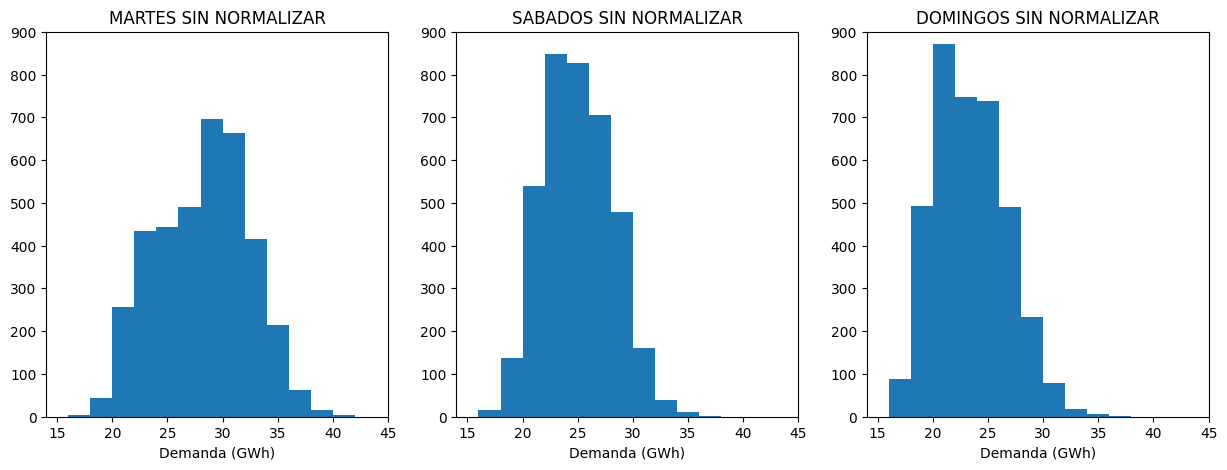

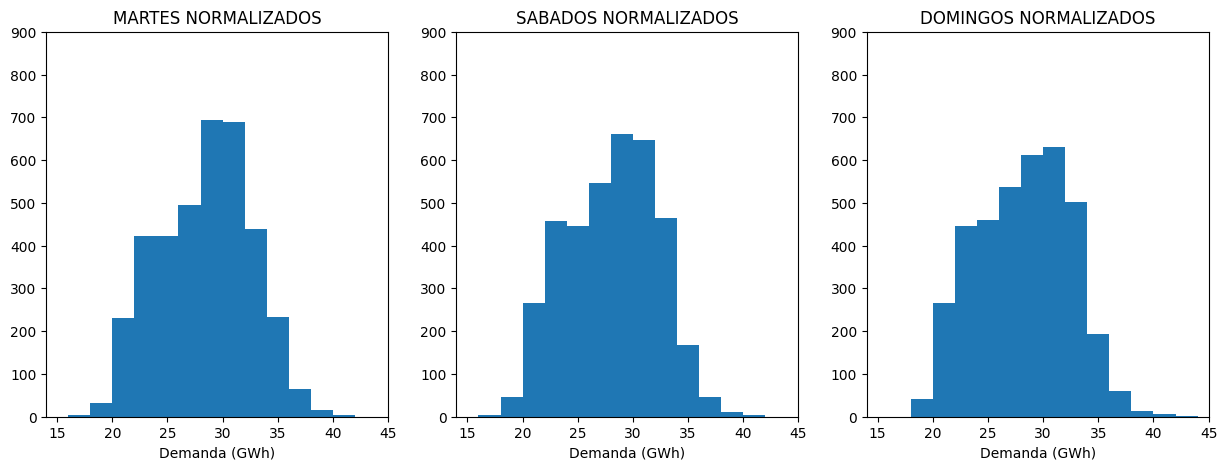

In [29]:
ancho = 15
alto = 5

plt.figure(figsize=(ancho,alto))

plt.subplot(1, 3, 1)
plt.title('MARTES SIN NORMALIZAR')
plt.xlim([14,45])
plt.ylim([0, 900])
plt.xlabel("Demanda (GWh)")
plt.hist(martes['Valor'], bins=bins3)

plt.subplot(1, 3, 2)
plt.title('SABADOS SIN NORMALIZAR')
plt.xlim([14,45])
plt.ylim([0, 900])
plt.xlabel("Demanda (GWh)")
plt.hist(sabados['Valor'], bins=bins3)

plt.subplot(1, 3, 3)
plt.title('DOMINGOS SIN NORMALIZAR')
plt.xlim([14,45])
plt.ylim([0, 900])
plt.xlabel("Demanda (GWh)")
plt.hist(domingos['Valor'], bins=bins3)

plt.show()

plt.figure(figsize=(ancho,alto))

plt.subplot(1, 3, 1)
plt.title('MARTES NORMALIZADOS')
plt.xlim([14,45])
plt.ylim([0, 900])
plt.xlabel("Demanda (GWh)")
plt.hist(martes['Valor_Normalizado1'], bins=bins3)

plt.subplot(1, 3, 2)
plt.title('SABADOS NORMALIZADOS')
plt.xlim([14,45])
plt.ylim([0, 900])
plt.xlabel("Demanda (GWh)")
plt.hist(sabados['Valor_Normalizado1'], bins=bins3)

plt.subplot(1, 3, 3)
plt.title('DOMINGOS NORMALIZADOS')
plt.xlim([14,45])
plt.ylim([0, 900])
plt.xlabel("Demanda (GWh)")
plt.hist(domingos['Valor_Normalizado1'], bins=bins3)

plt.show()

### Guardado de los datos

Para terminar, se guardan los datos en formato *csv*.

In [30]:
data.to_csv(path_or_buf="data.csv", sep=";", encoding="utf-8")

In [31]:
dtype={'Indice': np.int64,
       'Valor': np.float64,
       'Prevision': np.float64,
       'Dia': str,
       'Dia_Semana': str,
       'Hora': str,
       'Temperatura': np.float64,
       'Fecha': str,
       'Valor_Normalizado1': np.float64,
       'Valor_Normalizado2': np.float64,
       'Valor_Normalizado3_7d': np.float64,
       'Valor_Normalizado3_1d': np.float64,
       'Temperatura_Centrada0': np.float64,
       'Temperatura_Centrada1': np.float64,
       'Temperatura_Centrada2': np.float64,
       'Temperatura_Centrada3_7d': np.float64,
       'Temperatura_Centrada3_1d': np.float64}

data = pd.read_csv('data.csv', sep=';', index_col=0, dtype=dtype, parse_dates=['Fecha'])
data

,Indice,Valor,Prevision,Dia,Dia_Semana,Hora,Temperatura,Fecha,Valor_Normalizado1,Valor_Normalizado2,Valor_Normalizado3_7d,Valor_Normalizado3_1d,Temperatura_Centrada0,Temperatura_Centrada1,Temperatura_Centrada2,Temperatura_Centrada3_7d,Temperatura_Centrada3_1d
0,0,24.179,24.144,2021-01-01,V,00:00:00,4.0,2021-01-01 00:00:00,26.185886,1.000000,1.000000,1.000000,81.00,81.00,144.00,169.00,169.00
1,1,22.472,22.451,2021-01-01,V,01:00:00,3.0,2021-01-01 01:00:00,24.588018,1.000000,1.000000,1.000000,100.00,100.00,169.00,196.00,196.00
2,2,20.319,20.314,2021-01-01,V,02:00:00,4.0,2021-01-01 02:00:00,22.465793,1.000000,1.000000,1.000000,81.00,81.00,144.00,169.00,169.00
3,3,19.040,19.066,2021-01-01,V,03:00:00,4.0,2021-01-01 03:00:00,21.370285,1.000000,1.000000,1.000000,81.00,81.00,144.00,169.00,169.00
4,4,18.565,18.638,2021-01-01,V,04:00:00,4.0,2021-01-01 04:00:00,21.449848,1.000000,1.000000,1.000000,81.00,81.00,144.00,169.00,169.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26275,26275,28.979,29.018,2023-12-31,D,19:00:00,5.8,2023-12-31 19:00:00,33.753289,1.028901,1.028901,1.018069,51.84,51.84,104.04,125.44,125.44
26276,26276,28.383,27.995,2023-12-31,D,20:00:00,5.7,2023-12-31 20:00:00,31.959272,1.043876,1.043876,0.969093,53.29,53.29,106.09,127.69,127.69
26277,26277,25.818,25.348,2023-12-31,D,21:00:00,5.1,2023-12-31 21:00:00,28.288804,1.059200,1.059200,0.900340,62.41,62.41,118.81,141.61,141.61
26278,26278,23.627,23.213,2023-12-31,D,22:00:00,4.4,2023-12-31 22:00:00,25.609085,1.043642,1.043642,0.892248,73.96,73.96,134.56,158.76,158.76
